In [115]:
# import shutil
#!cp -R '/content/drive/My Drive/COVID-19/Dataset_2' '/content/'

In [116]:
#mv '/content/X-Ray Image DataSet' '/content/dataset-2'

In [117]:
'''import os
ds_path = '/content/dataset-2'
cat_list = ['No_findings', 'Pneumonia']
for cat in cat_list:
    cat_path = os.path.join(ds_path, cat)
    file_count = len(os.listdir(cat_path))
    print(file_count)
    train_count = int(0.7 * file_count)
    file_list = os.listdir(cat_path)
    train_list = file_list[:train_count]
    val_list = file_list[train_count:]
    for train_file in train_list:
        src_path = os.path.join(cat_path, train_file)
        dest_path = os.path.join('/content/drive/My Drive/COVID-19/X-Ray Image DataSet/train', cat)
        shutil.move(src_path, dest_path)
    for val_file in val_list:
        src_path = os.path.join(cat_path, val_file)
        dest_path = os.path.join('/content/drive/My Drive/COVID-19/X-Ray Image DataSet/val', cat)
        shutil.move(src_path, dest_path)

ds_path = '/content/drive/My Drive/COVID-19/Dataset_2/Covid-19'
cat_list = ['Covid-19', 'No_findings', 'Pneumonia']
# print(os.listdir())
for cat in cat_list:
    print(len(os.path.join(ds_path, cat)))
    # file'''

"import os\nds_path = '/content/dataset-2'\ncat_list = ['No_findings', 'Pneumonia']\nfor cat in cat_list:\n    cat_path = os.path.join(ds_path, cat)\n    file_count = len(os.listdir(cat_path))\n    print(file_count)\n    train_count = int(0.7 * file_count)\n    file_list = os.listdir(cat_path)\n    train_list = file_list[:train_count]\n    val_list = file_list[train_count:]\n    for train_file in train_list:\n        src_path = os.path.join(cat_path, train_file)\n        dest_path = os.path.join('/content/drive/My Drive/COVID-19/X-Ray Image DataSet/train', cat)\n        shutil.move(src_path, dest_path)\n    for val_file in val_list:\n        src_path = os.path.join(cat_path, val_file)\n        dest_path = os.path.join('/content/drive/My Drive/COVID-19/X-Ray Image DataSet/val', cat)\n        shutil.move(src_path, dest_path)\n\nds_path = '/content/drive/My Drive/COVID-19/Dataset_2/Covid-19'\ncat_list = ['Covid-19', 'No_findings', 'Pneumonia']\n# print(os.listdir())\nfor cat in cat_list:\

In [118]:
%matplotlib inline

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Dropout, MaxPooling2D, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt

In [2]:
bs = 32
no_epochs = 1
img_height = 224
img_width = 224
train_dir = '/content/Dataset_2/train'
val_dir = '/content/Dataset_2/val'

In [173]:
train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    horizontal_flip=True,
    zoom_range=0.3
)

In [174]:
validation_data_generator = ImageDataGenerator(
    rescale=1./255
)

In [175]:
train_data = train_data_generator.flow_from_directory(
    batch_size=bs,
    directory=train_dir,
    shuffle=True,
    target_size=(img_height, img_width),
    class_mode='categorical'
)

Found 652 images belonging to 3 classes.


In [176]:
val_data = validation_data_generator.flow_from_directory(
    batch_size=bs,
    directory=val_dir,
    shuffle=True,
    target_size=(img_height, img_width),
    class_mode='categorical'
)

Found 288 images belonging to 3 classes.


In [40]:
def conv_block(out_channels, filter_dim=3, stride=1):
    # for_pad = lambda s: s if s > 2 else 3
    block = Sequential()
    '''if filter_dim == 1:
      block.add(Conv2DTranspose(out_channels,3, strides=(1,1), padding='valid', activation=None))
    else:
      block.add(Conv2D(out_channels, filter_dim, strides=(1,1), padding='same', activation=None))'''
    block.add(Conv2D(out_channels, filter_dim, strides=(1,1), padding='same', activation=None))
    block.add(BatchNormalization())
    block.add(LeakyReLU(alpha=0.1))
    return block

In [41]:
def triple_conv(out_channels, in_channels):
    block = Sequential()
    block.add(conv_block(out_channels, 3))

    block.add(conv_block(in_channels, filter_dim=1))
    '''block.add(Conv2DTranspose(in_channels,3, strides=(1,1), padding='valid', activation=None))
    block.add(BatchNormalization())
    block.add(LeakyReLU(alpha=0.1))'''

    block.add(conv_block(out_channels, 3))
    return block

In [42]:
model = Sequential()
model.add(Input(shape=(img_height, img_width, 3)))
model.add(conv_block(8, 3))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(conv_block(16, 3))
model.add(MaxPooling2D())
model.add(triple_conv(32, 16))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(triple_conv(64, 32))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(triple_conv(128, 64))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(triple_conv(256, 128))
model.add(conv_block(128, filter_dim=1))
model.add(conv_block(256, 3))
model.add(conv_block(3, 3))
model.add(Flatten())
#model.add(Dense(192))
model.add(Dense(3))

In [43]:
opt = Adam(learning_rate=3e-5)
model.compile(optimizer=opt, loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_23 (Sequential)   (None, 224, 224, 8)       256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
sequential_24 (Sequential)   (None, 112, 112, 16)      1232      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
sequential_25 (Sequential)   (None, 56, 56, 32)        10128     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
sequential_29 (Sequential)   (None, 28, 28, 64)      

In [130]:
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('CovidModel.h5', save_best_only=True, monitor='val_loss', mode='min')

In [131]:
model.load_weights('CovidModel.h5')
no_epochs = 60

In [ ]:
history = model.fit(
    train_data,
    epochs=no_epochs,
    validation_data=val_data,
    steps_per_epoch=None,
    validation_steps=None,
    callbacks=[mcp_save]
)

In [133]:
#print(history.history.keys())

In [134]:
print(history.history['accuracy'])
print(history.history['val_accuracy'])

[0.8220859169960022, 0.8481594920158386, 0.8619632124900818, 0.8619632124900818, 0.8788343667984009, 0.8865030407905579, 0.8711656332015991, 0.8680981397628784, 0.8880367875099182, 0.8711656332015991, 0.8773006200790405, 0.8680981397628784, 0.8849693536758423, 0.8726993799209595, 0.8726993799209595, 0.8773006200790405, 0.8650306463241577, 0.8865030407905579, 0.8834356069564819, 0.8834356069564819, 0.8865030407905579, 0.8788343667984009, 0.8880367875099182, 0.8819018602371216, 0.8880367875099182, 0.8987730145454407, 0.900306761264801, 0.9018405079841614, 0.9049080014228821, 0.8573619723320007, 0.8680981397628784, 0.9018405079841614, 0.9064416885375977, 0.8911042809486389, 0.8941717743873596, 0.900306761264801, 0.9064416885375977, 0.907975435256958, 0.8926380276679993, 0.9110429286956787, 0.8865030407905579, 0.8972392678260803, 0.9064416885375977, 0.8849693536758423, 0.9049080014228821, 0.907975435256958, 0.900306761264801, 0.9064416885375977, 0.8941717743873596, 0.89570552110672, 0.9033

In [135]:
print(max(history.history['val_accuracy']))
print(min(history.history['val_loss']))

0.8611111044883728
0.35889944434165955


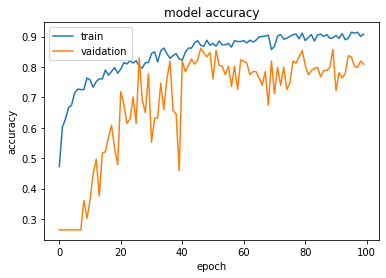

In [142]:
a = [0.47239264845848083, 0.6012269854545593, 0.6288343667984009, 0.6656441688537598, 0.6748466491699219, 0.7147239446640015, 0.7269938588142395, 0.7254601120948792, 0.7254601120948792, 0.7638036608695984, 0.7576687335968018, 0.7331288456916809, 0.7515337467193604, 0.7607361674308777, 0.7607361674308777, 0.7898772954940796, 0.7730061411857605, 0.7852760553359985, 0.7975460290908813, 0.7791411280632019, 0.7929447889328003, 0.8144171833992004, 0.8098159432411194, 0.8205521702766418, 0.8128834366798401, 0.8205521702766418, 0.8021472096443176, 0.796012282371521, 0.8144171833992004, 0.8144171833992004, 0.8435583114624023, 0.849693238735199, 0.8159509301185608, 0.8527607321739197, 0.8619632124900818, 0.8435583114624023, 0.8282208442687988, 0.8374233245849609, 0.8435583114624023, 0.8266870975494385]
a.extend(history.history['accuracy'])

b = [0.2638888955116272, 0.2638888955116272, 0.2638888955116272, 0.2638888955116272, 0.2638888955116272, 0.2638888955116272, 0.2638888955116272, 0.2638888955116272, 0.3611111044883728, 0.3020833432674408, 0.3611111044883728, 0.4479166567325592, 0.4965277910232544, 0.375, 0.5173611044883728, 0.5208333134651184, 0.5694444179534912, 0.6076388955116272, 0.53125, 0.4791666567325592, 0.71875, 0.6770833134651184, 0.6145833134651184, 0.6284722089767456, 0.7013888955116272, 0.6145833134651184, 0.8298611044883728, 0.6909722089767456, 0.6493055820465088, 0.7777777910232544, 0.5520833134651184, 0.6319444179534912, 0.6319444179534912, 0.7465277910232544, 0.6597222089767456, 0.7604166865348816, 0.8194444179534912, 0.65625, 0.6458333134651184, 0.4583333432674408]
b.extend(history.history['val_accuracy'])

plt.plot(a)
plt.plot(b)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vaidation'], loc='upper left')
plt.show()

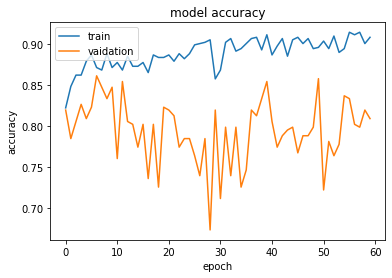

In [137]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vaidation'], loc='upper left')
plt.show()

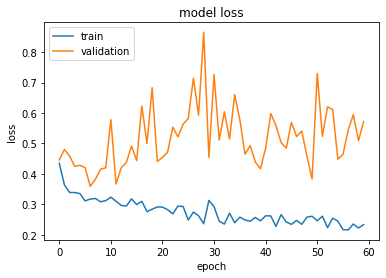

In [138]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [139]:
# !cp CovidModel.h5 '/content/drive/My Drive/COVID-19/'

In [140]:
#!cp '/content/drive/My Drive/COVID-19/CovidModel_1.h5' '/content/'

In [141]:
#print("temp")

# **Recall**

In [45]:
validation_data_generator = ImageDataGenerator(
    rescale=1./255
)

In [46]:
val_data = validation_data_generator.flow_from_directory(
    batch_size=1,
    directory=val_dir,
    shuffle=False,
    target_size=(img_height, img_width),
    class_mode='categorical'
)
idx2label_dict = {val_data.class_indices[k]: k for k in val_data.class_indices}

Found 288 images belonging to 3 classes.


In [47]:
model.load_weights('CovidModel.h5')
y_pred = model.predict_classes(val_data)
y_true = val_data.classes
print(y_pred.shape,y_true.shape)

(288,) (288,)


In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [49]:
def get_key(mydict,val): 
    for key, value in mydict.items(): 
         if val == value: 
             return key 

In [50]:
def calReCall(y_true,y_pred,idx2label_dict,class_name):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [idx2label_dict[int(i)] for i in "012"],
                  columns = [idx2label_dict[int(i)] for i in "012"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True,linewidths=.5)
    id = get_key(idx2label_dict,class_name)
    out = np.sum(cm, axis=1)
    return cm[id][id]/out[id]

Recall:  0.868421052631579


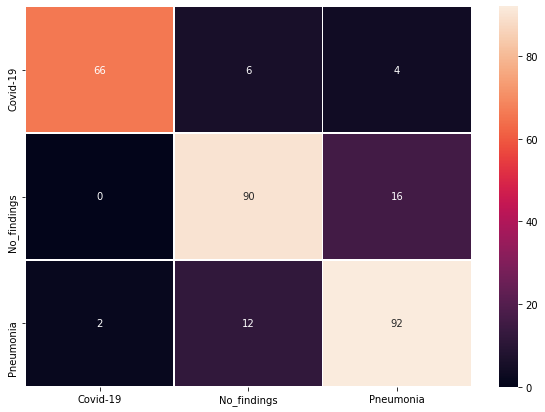

In [51]:
recallVal = calReCall(y_true,y_pred,idx2label_dict,'Covid-19')
print("Recall: ",recallVal)